<a href="https://colab.research.google.com/github/larasauser/master/blob/main/imgprep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#Drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
import os
import rasterio
import numpy as np
from glob import glob

def crop_to_valid_ndvi_bounds(img, transform, min_val=-1.0, max_val=1.0):
    """Retourne l'image recadrée sur les pixels avec valeurs NDVI valides."""
    valid_mask = (img >= min_val) & (img <= max_val)

    if not np.any(valid_mask):
        raise ValueError("Aucune valeur NDVI valide trouvée dans l'image.")

    rows, cols = np.where(valid_mask)
    row_min, row_max = rows.min(), rows.max()
    col_min, col_max = cols.min(), cols.max()

    cropped_img = img[row_min:row_max+1, col_min:col_max+1]
    new_transform = transform * rasterio.Affine.translation(col_min, row_min)

    return cropped_img, new_transform

# Dossiers
input_dir = "/content/drive/MyDrive/NDVI_herens_Landsat8_10/"
output_dir = "/content/drive/MyDrive/NDVI_herens_Landsat8_10/NDVI_herens_Landsat8_10_cropped/"
os.makedirs(output_dir, exist_ok=True)

# Traitement par lot
image_paths = glob(os.path.join(input_dir, "*.tif"))
print(f"{len(image_paths)} image(s) trouvée(s).")

for path in image_paths:
    try:
        with rasterio.open(path) as src:
            img = src.read(1).astype(np.float32)
            profile = src.profile
            transform = src.transform

        cropped_img, new_transform = crop_to_valid_ndvi_bounds(img, transform)

        profile.update({
            "height": cropped_img.shape[0],
            "width": cropped_img.shape[1],
            "transform": new_transform,
            "dtype": rasterio.float32
        })

        out_path = os.path.join(output_dir, os.path.basename(path))
        with rasterio.open(out_path, "w", **profile) as dst:
            dst.write(cropped_img, 1)

        print(f"✔ {os.path.basename(path)} recadrée avec succès.")

    except Exception as e:
        print(f"❌ Erreur avec {os.path.basename(path)} : {e}")


72 image(s) trouvée(s).
✔ NDVI_2023-01-24.tif recadrée avec succès.
✔ NDVI_2013-11-12.tif recadrée avec succès.
✔ NDVI_2022-12-07.tif recadrée avec succès.
✔ NDVI_2015-04-08.tif recadrée avec succès.
✔ NDVI_2015-08-30.tif recadrée avec succès.
✔ NDVI_2015-04-24.tif recadrée avec succès.
✔ NDVI_2023-11-24.tif recadrée avec succès.
✔ NDVI_2016-04-10.tif recadrée avec succès.
✔ NDVI_2020-08-27.tif recadrée avec succès.
✔ NDVI_2013-11-28.tif recadrée avec succès.
✔ NDVI_2021-12-20.tif recadrée avec succès.
✔ NDVI_2015-01-02.tif recadrée avec succès.
✔ NDVI_2021-02-19.tif recadrée avec succès.
✔ NDVI_2014-09-28.tif recadrée avec succès.
✔ NDVI_2020-01-16.tif recadrée avec succès.
✔ NDVI_2016-03-09.tif recadrée avec succès.
✔ NDVI_2013-04-18.tif recadrée avec succès.
✔ NDVI_2023-11-08.tif recadrée avec succès.
✔ NDVI_2017-01-23.tif recadrée avec succès.
✔ NDVI_2014-08-27.tif recadrée avec succès.
✔ NDVI_2019-08-09.tif recadrée avec succès.
✔ NDVI_2018-10-09.tif recadrée avec succès.
✔ NDVI_2

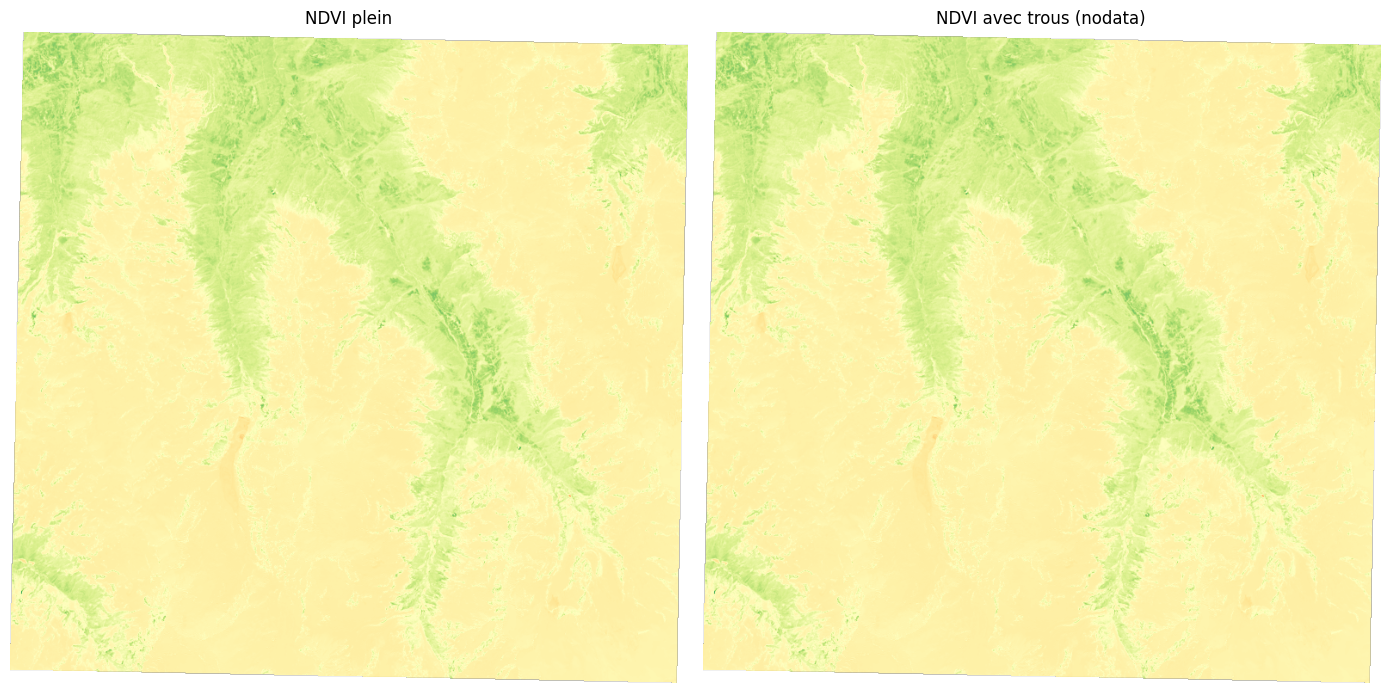

In [27]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

def read_ndvi(path):
    with rasterio.open(path) as src:
        ndvi = src.read(1).astype(np.float32)
        nodata = src.nodata
        if nodata is not None:
            ndvi = np.where(ndvi == nodata, np.nan, ndvi)
    return ndvi

# Chemins des images à comparer
path_full = '/content/drive/MyDrive/NDVI_herens_Landsat8_10/NDVI_2015-04-24.tif'
path_with_holes = '/content/drive/MyDrive/NDVI_herens_Landsat8_10/NDVI_herens_Landsat8_10_cropped/NDVI_2015-04-24.tif'

# Lire les images
ndvi_full = read_ndvi(path_full)
ndvi_holes = read_ndvi(path_with_holes)

# Affichage côte à côte
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

vmin, vmax = -1, 1  # plage NDVI classique

axes[0].imshow(ndvi_full, cmap='RdYlGn', vmin=vmin, vmax=vmax)
axes[0].set_title('NDVI plein')
axes[0].axis('off')

axes[1].imshow(ndvi_holes, cmap='RdYlGn', vmin=vmin, vmax=vmax)
axes[1].set_title('NDVI avec trous (nodata)')
axes[1].axis('off')

plt.tight_layout()
plt.show()


In [23]:
import os
import rasterio
import numpy as np
from glob import glob

def create_random_holes_nodata(img, min_size=50, max_size=150, max_holes=5, nodata_val=-9999):
    img_with_holes = img.copy()
    h, w = img.shape
    for _ in range(np.random.randint(1, max_holes + 1)):
        x = np.random.randint(0, w - max_size)
        y = np.random.randint(0, h - max_size)
        dx = np.random.randint(min_size, max_size + 1)
        dy = np.random.randint(min_size, max_size + 1)
        img_with_holes[y:y+dy, x:x+dx] = nodata_val
    return img_with_holes

input_dir = '/content/drive/MyDrive/NDVI_herens_Landsat8_10/'
output_dir = '/content/drive/MyDrive/NDVI_herens_Landsat8_10/NDVI_herens_Landsat8_10_holes/'
os.makedirs(output_dir, exist_ok=True)

image_paths = glob(os.path.join(input_dir, '*.tif'))
print(f"Nombre d'images à traiter : {len(image_paths)}")

success_count = 0
fail_count = 0

for path in image_paths:
    try:
        with rasterio.open(path) as src:
            img = src.read(1).astype(np.float32)
            profile = src.profile

        # Ajouter trous avec min_size et max_size
        img_with_holes = create_random_holes_nodata(img)

        # Mise à jour profil
        profile.update(
            dtype=rasterio.float32,
            nodata=profile.get('nodata', -9999),
            compress='lzw'
        )

        out_path = os.path.join(output_dir, os.path.basename(path))
        with rasterio.open(out_path, 'w', **profile) as dst:
            dst.write(img_with_holes, 1)

        print(f"✔ Image traitée et sauvegardée : {os.path.basename(path)}")
        success_count += 1

    except Exception as e:
        print(f"❌ Erreur sur {os.path.basename(path)} : {e}")
        fail_count += 1

print(f"\nTraitement terminé. {success_count} images traitées avec succès, {fail_count} erreurs.")


Nombre d'images à traiter : 72
✔ Image traitée et sauvegardée : NDVI_2023-01-24.tif
✔ Image traitée et sauvegardée : NDVI_2013-11-12.tif
✔ Image traitée et sauvegardée : NDVI_2022-12-07.tif
✔ Image traitée et sauvegardée : NDVI_2015-04-08.tif
✔ Image traitée et sauvegardée : NDVI_2015-08-30.tif
✔ Image traitée et sauvegardée : NDVI_2015-04-24.tif
✔ Image traitée et sauvegardée : NDVI_2023-11-24.tif
✔ Image traitée et sauvegardée : NDVI_2016-04-10.tif
✔ Image traitée et sauvegardée : NDVI_2020-08-27.tif
✔ Image traitée et sauvegardée : NDVI_2013-11-28.tif
✔ Image traitée et sauvegardée : NDVI_2021-12-20.tif
✔ Image traitée et sauvegardée : NDVI_2015-01-02.tif
✔ Image traitée et sauvegardée : NDVI_2021-02-19.tif
✔ Image traitée et sauvegardée : NDVI_2014-09-28.tif
✔ Image traitée et sauvegardée : NDVI_2020-01-16.tif
✔ Image traitée et sauvegardée : NDVI_2016-03-09.tif
✔ Image traitée et sauvegardée : NDVI_2013-04-18.tif
✔ Image traitée et sauvegardée : NDVI_2023-11-08.tif
✔ Image traitée

In [12]:
import rasterio

with rasterio.open('/content/drive/MyDrive/NDVI_herens_Landsat8_10/NDVI_2023-08-20.tif') as src:
    width = src.width      # nombre de colonnes (pixels en X)
    height = src.height    # nombre de lignes (pixels en Y)
    print(f"Taille de l'image : {width} x {height} pixels")


Taille de l'image : 788 x 757 pixels


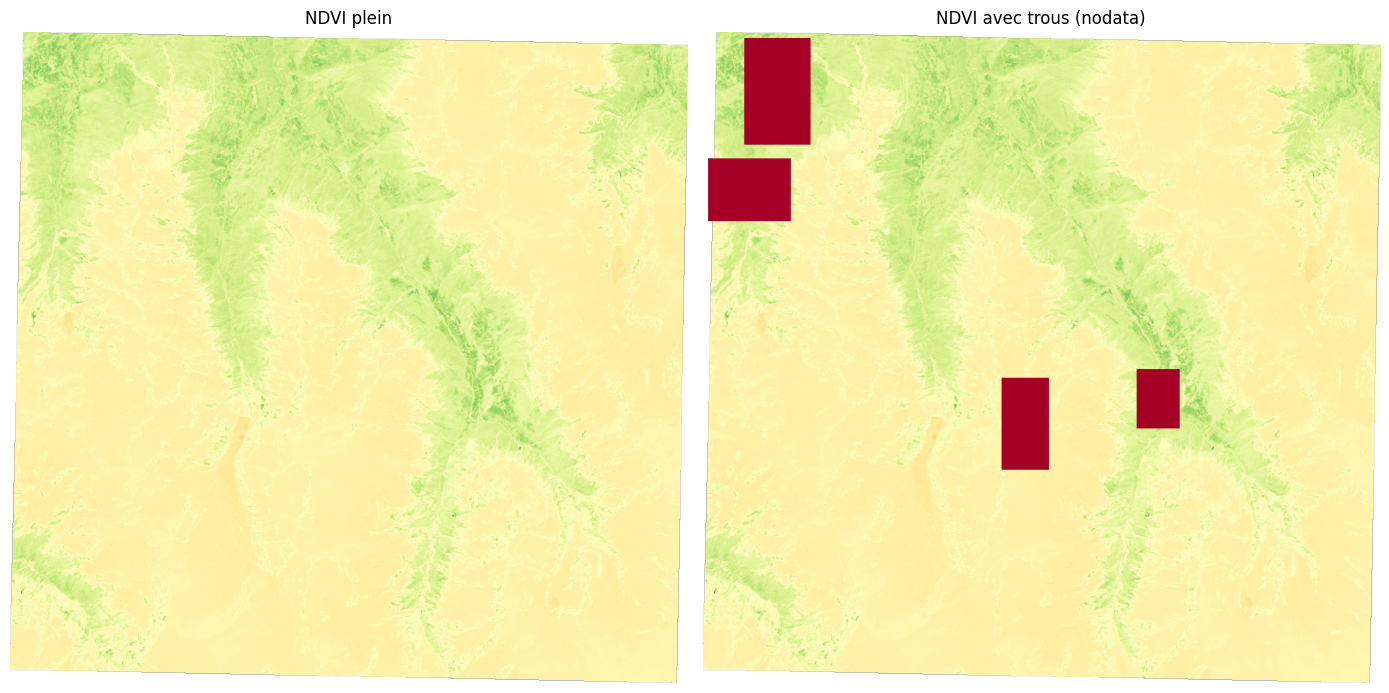

In [25]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

def read_ndvi(path):
    with rasterio.open(path) as src:
        ndvi = src.read(1).astype(np.float32)
        nodata = src.nodata
        if nodata is not None:
            ndvi = np.where(ndvi == nodata, np.nan, ndvi)
    return ndvi

# Chemins des images à comparer
path_full = '/content/drive/MyDrive/NDVI_herens_Landsat8_10/NDVI_2015-04-24.tif'
path_with_holes = '/content/drive/MyDrive/NDVI_herens_Landsat8_10/NDVI_herens_Landsat8_10_holes/NDVI_2015-04-24.tif'

# Lire les images
ndvi_full = read_ndvi(path_full)
ndvi_holes = read_ndvi(path_with_holes)

# Affichage côte à côte
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

vmin, vmax = -1, 1  # plage NDVI classique

axes[0].imshow(ndvi_full, cmap='RdYlGn', vmin=vmin, vmax=vmax)
axes[0].set_title('NDVI plein')
axes[0].axis('off')

axes[1].imshow(ndvi_holes, cmap='RdYlGn', vmin=vmin, vmax=vmax)
axes[1].set_title('NDVI avec trous (nodata)')
axes[1].axis('off')

plt.tight_layout()
plt.show()
